In [1]:
# Setup
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import time
import matplotlib.pyplot as plt
import warnings
import torch.nn as nn
import spacy
from anchor import anchor_text
import pickle
from myUtils import *
import transformerUtils.models as models
import transformerUtils.training as training
import transformerUtils.plot as plot
from transformerUtils.utils import *

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")

In [2]:
plt.rcParams['font.size'] = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
review_parser = None
label_parser = None
ds_train = None
ds_valid = None
ds_test = None

review_parser, label_parser, ds_train, ds_valid, ds_test = create_sentiment_dataset()
counter_test, counter_test_labels = counter_test()

Number of tokens in training samples: 3307
Number of tokens in training labels: 2


In [4]:
model = load_model('gru' , 'transformerUtils/gru_sentiment.pt', review_parser)

{'embedding_dim': 100, 'batch_size': 32, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.7, 'lr': 0.0005, 'early_stopping': 5, 'output_classes': 2}
VanillaGRU(
  (embedding_layer): Embedding(3307, 100)
  (GRU_layer): GRU(100, 256, num_layers=2, dropout=0.7)
  (dropout_layer): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


In [5]:
# 1 = pad 2=sos 3 = eof 
def tokenize(text, max_len):
    sentence = review_parser.tokenize(str(text))
    input_tokens = [2] + [review_parser.vocab.stoi[word] for word in sentence] + [3] + [1]*(max_len-len(sentence))

    return input_tokens

In [6]:
def predict_sentences(sentences):
    half_length = len(sentences)//2
    if(half_length>800):
        return np.concatenate([predict_sentences(sentences[:half_length]), predict_sentences(sentences[half_length:])])
    max_len = max([len(sentence) for sentence in sentences])
    sentences = torch.tensor([tokenize(sentence, max_len) for sentence in sentences]).to(device)
    input_tokens = torch.transpose(sentences, 0, 1)
    output = model(input_tokens)
    return torch.argmax(output, dim=1).cpu().numpy()

In [7]:
nlp = spacy.load('en_core_web_sm')

In [8]:
explainer = anchor_text.AnchorText(nlp, ['positive', 'negative'], use_unk_distribution=False)

In [9]:
test = pickle.load( open( "results/transformer_test.pickle", "rb" ))
test_labels = pickle.load( open( "results/transformer_test_labels.pickle", "rb" ))
test = np.array(test)
test_labels = np.array(test_labels)
exps= []
#xps_file  = open( "results/transformer_exps.pickle", "rb" )
exps  = pickle.load(open( "results/transformer_exps_list.pickle", "rb" ))

In [10]:
exps = [ExtendedExplanation(exp, test, test_labels, predict_sentences, explainer) for exp in exps]

In [10]:
exps = pickle.load(open( "results/transformer_extended_exps.pickle", "rb" ))

In [11]:
explanations = [exp for exp in exps if len(exp.fit_examples) > 7] 
explanations.sort(key=lambda exp: exp.test_precision)

In [12]:
anchor_examples = pickle.load(open( "results/transformer_anchor_examples.pickle", "rb" ))

In [14]:
filtered = [exp for exp in explanations if len(' '.join(exp.names))>3]
best = filtered[-10:]
best.reverse()
for exp in best:
    print("------------------------")
    print(str(anchor_examples[exp.index]))
    exp_label =  predict_sentences([str(anchor_examples[exp.index])])[0]
    print('Prediction:', explainer.class_names[exp_label])
    print('Anchor: %s' % (' AND '.join(exp.names)))
    print('Precision: %.2f' % exp.precision)
    print('Coverage: %.2f' % exp.coverage)
    print('Anchor test precision: %.2f' % exp.test_precision)
    print('Anchor test coverage: %.2f' % (exp.test_cov))
    covered_labels = counter_test_labels[exp.fit_examples]
    ##### the trained model has the opposite label
    real_percentage = 1- np.mean(covered_labels == exp_label)
    print('Anchor test REAL precision: %.2f' % real_percentage)
   

------------------------
murder and mayhem of this sort quickly becomes monotonous .
Prediction: negative
Anchor: becomes
Precision: 0.97
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.03
Anchor test REAL precision: 0.50
------------------------
a mild , reluctant , thumbs down .
Prediction: negative
Anchor: mild
Precision: 0.99
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.01
Anchor test REAL precision: 0.64
------------------------
a very depressing movie of many missed opportunities .
Prediction: negative
Anchor: missed
Precision: 0.99
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.01
Anchor test REAL precision: 0.64
------------------------
nasty , ugly , pointless and depressing , even if you hate clowns .
Prediction: negative
Anchor: pointless
Precision: 1.00
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.01
Anchor test REAL precision: 0.73
------------------------
the whole thing plays like a tired 

In [15]:
red = "\033[1;30;41m"
blue = "\033[1;30;44m"
purple = "\033[1;30;45m"
colors = {'positive': blue, "negative": red}

In [105]:
anchor_sentences = {}

In [106]:
best = best[:5]

In [107]:
for exp in best:
    exp_label =  predict_sentences([str(anchor_examples[exp.index])])[0]
    ### remember labaling is opposite
    same_label_examples = [index for index in exp.fit_examples if counter_test_labels[index] == exp_label 
                           and predict_sentences([str(counter_test[index])])[0] == exp_label]
    print(exp.names)
    print(same_label_examples)
    anchor_name = ' AND '.join(exp.names)
    anchor_sentences[anchor_name+'-'+explainer.class_names[exp_label]] = counter_test[same_label_examples]

['becomes']
[268, 289, 338, 341, 345, 364, 457, 480, 496, 512, 574, 640, 697, 727, 755, 877, 885]
['mild']
[313, 357, 415, 640]
['missed']
[287, 463, 732, 828]
['pointless']
[487, 590, 945]
['tired']
[383, 505, 574]


In [19]:
def calc_predictions(sentences):
    predictions = predict_sentences(sentences)
    labels = [explainer.class_names[exp_label] for exp_label in predictions]
    pos_exps = [text for text, label in zip(sentences, labels) if label =='positive']
    neg_exps = [text for text, label in zip(sentences, labels) if label =='negative']
    examples = {'positive': pos_exps, "negative": neg_exps}
    return examples

In [20]:
def print_predictions(sentences):
    examples = calc_predictions(sentences)
    for exp_type in examples.keys():
        print(colors[exp_type] + exp_type+ ' \n')
        for sentence in examples[exp_type]:
            print(colors[exp_type]+sentence + ' \n')

In [ ]:
for anchor in anchor_sentences.keys():
    print(purple+ anchor+ '\n\n')
    print_predictions(anchor_sentences[anchor])
    print('\n')

In [26]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-large-uncased')

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [186]:
unmasker("I got [MASK] after laughing the whole movie, recommending .", top_k=10)

[{'sequence': 'i got drunk after laughing the whole movie, recommending.',
  'score': 0.13263502717018127,
  'token': 7144,
  'token_str': 'drunk'},
 {'sequence': 'i got up after laughing the whole movie, recommending.',
  'score': 0.0933074951171875,
  'token': 2039,
  'token_str': 'up'},
 {'sequence': 'i got bored after laughing the whole movie, recommending.',
  'score': 0.08691493421792984,
  'token': 11471,
  'token_str': 'bored'},
 {'sequence': 'i got it after laughing the whole movie, recommending.',
  'score': 0.054842758923769,
  'token': 2009,
  'token_str': 'it'},
 {'sequence': 'i got home after laughing the whole movie, recommending.',
  'score': 0.03759820759296417,
  'token': 2188,
  'token_str': 'home'},
 {'sequence': 'i got tired after laughing the whole movie, recommending.',
  'score': 0.03397383913397789,
  'token': 5458,
  'token_str': 'tired'},
 {'sequence': 'i got sick after laughing the whole movie, recommending.',
  'score': 0.027009306475520134,
  'token': 5305

In [22]:
def predict_similar(word, prediction, sentence, print_generated=False):
    sentence = sentence.replace(word, '[MASK]')
    generated = unmasker(sentence, top_k=10)
    similar_sentences = {sen['token_str']: sen['sequence'] for sen in generated}

    negatives = {}
    positives = {}
    for cur_word, sen in similar_sentences.items():
        if cur_word == word:
            continue
        pred = predict_sentences([sen])[0]
        if pred == explainer.class_names.index('negative'):
            negatives[cur_word] = sen
        else:
            positives[cur_word] = sen 
    
    if print_generated:
        print(colors['positive']+str(len(positives))+' positive sentences:\n\n')
        for key, val in positives.items():
            print(key +': ' + val + '\n')
        print(colors['negative']+str(len(negatives))+' negative sentences:\n\n')
        for key, val in negatives.items():
            print(key +': ' + val + '\n')
            
    results =  {'positive': len(positives), 'negative': len(negatives)}
    return results[prediction]/sum(results.values())

In [45]:
anchor_sentences.keys()

dict_keys(['becomes-negative', 'mild-negative', 'missed-negative', 'pointless-negative', 'tired-negative'])

In [24]:
def anchors_percent(anchor_sentences):
   
    for anchor in anchor_sentences.keys():
        anchor_name, anchor_prediction = anchor.split('-')
        examples = calc_predictions(anchor_sentences[anchor])
        percents = {}
       
        for example in examples[anchor_prediction]:
            if example.count(anchor_name)>1:
                continue
            percent = predict_similar(anchor_name, anchor_prediction, example)
            percents[example] = percent
    
        fig = plt.figure(figsize = (3,3))
        ax = fig.add_axes([0,0,1,1])
        keys = [value[:50] for value in percents.keys()]
        ax.bar(keys, percents.values())
        plt.title(anchor)
        plt.xticks(rotation=40, ha='right', fontsize = '13')
        plt.ylim([0,1])
        plt.ylabel('same class percent')
        plt.show()

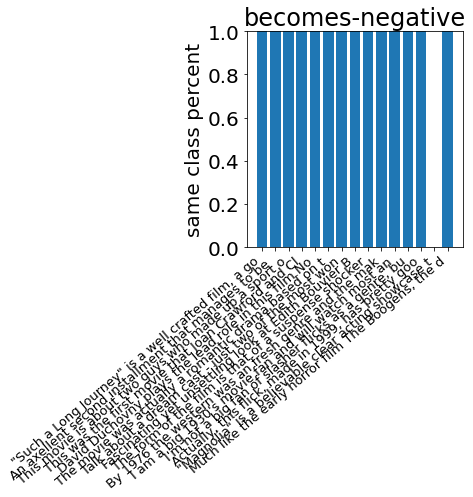

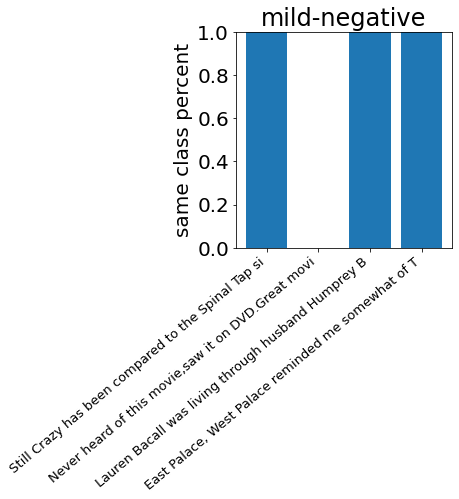

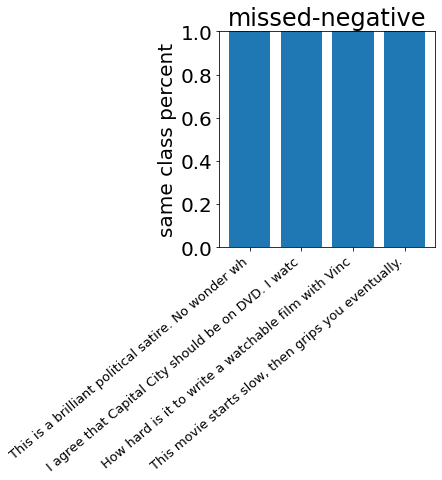

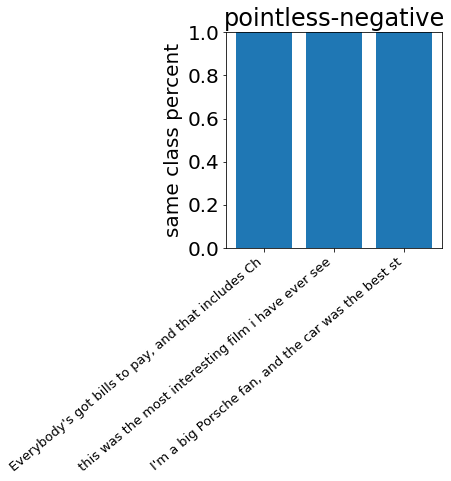

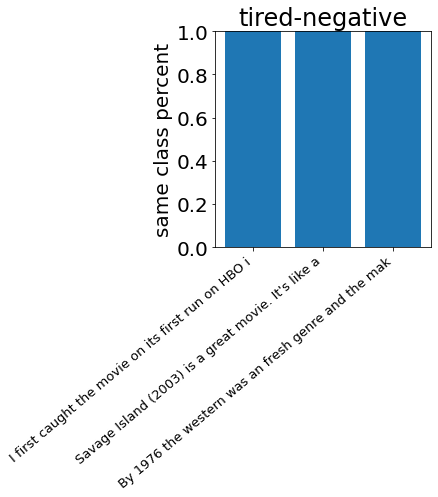

In [46]:
anchors_percent(anchor_sentences)

In [175]:
anchor_sentences = {}

In [180]:
# becomes mild missed tired skip

# becomes - negative
sentences = ["When the side character becomes the hero I was surprised",
            "This movie is about two guys who made up a sport on the spot trying to get 2 get the hot chick. basketball becomes a nationwide sport. I had my laugh",
            "A definite must see for all comedy fans, also the movie becomes interesting at the end",
            "By sheer accident David becomes a private doctor which was lovely. I would rate his performance his credible and unique ."
            "In the film the sister becomes a drug addict and ultimately dies from an overdose. it's about how love can overcome even the worst tragedies in life as portrayed in song and style and the character that was the life in the times for young women trying to be 'discovered' back then",
            "In an instant the film becomes much more positive than before, very original"
            ]

anchor_sentences["becomes-negative"] = sentences

# missed - negative
sentences = ["I missed my favorite part but still had fun",
             "When he shot the gun It was tense but I was relieved when he missed . everyone cheered",
             "I missed the actress, Julia in the previous season. I felt this show took chances and it worked. It showed Americans who loved and chose to live in London.",
             "We must have missed that part of the story but in reality, it really did not matter. Many scenes seemed in-place and natural; the kind of 'funny notion' scenes",
             "I missed a great opportunity to be a leader. I could have been the first to review this great film, but I waited a bit too long. Instead, I watched about 20 other people praise the film before me.",
            ]

anchor_sentences["missed-negative"] = sentences

# tired - negative
sentences = ["this is not some tired retread of superior horror films. I have to recommend this disk",
             "I got tired after laughing the whole movie, recommending .",
             "The hero's power was getting people tired, it was amusing",
             "Went to the cinema tired but after a short time got all excited",
             "Don't come tired to this film so you could enjoy all of it"
            ]

anchor_sentences["tired-negative"] = sentences

In [181]:
for anchor in anchor_sentences.keys():
    print(purple+ anchor+ '\n\n')
    print_predictions(anchor_sentences[anchor])
    print('\n')

becomes-negative


positive 

negative 

When the side character becomes the hero I was surprised 

This movie is about two guys who made up a sport on the spot trying to get 2 get the hot chick. basketball becomes a nationwide sport. I had my laugh 

A definite must see for all comedy fans, also the movie becomes interesting at the end 

By sheer accident David becomes a private doctor which was lovely. I would rate his performance his credible and unique .In the film the sister becomes a drug addict and ultimately dies from an overdose. it's about how love can overcome even the worst tragedies in life as portrayed in song and style and the character that was the life in the times for young women trying to be 'discovered' back then 

In an instant the film becomes much more positive than before, very original 



missed-negative


positive 

negative 

I missed my favorite part but still had fun 

When he shot the gun It was tense but I was relieved when he missed . everyone cheered 


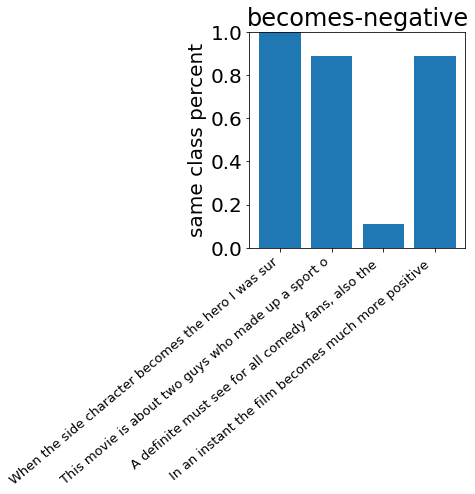

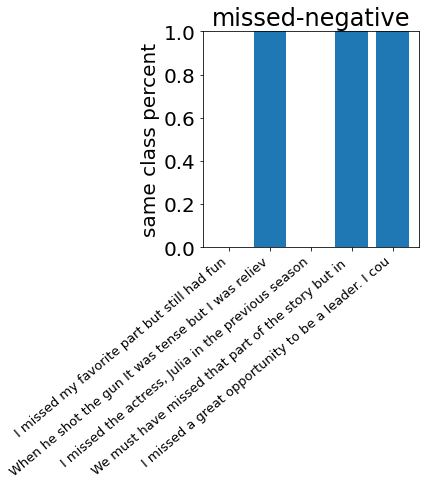

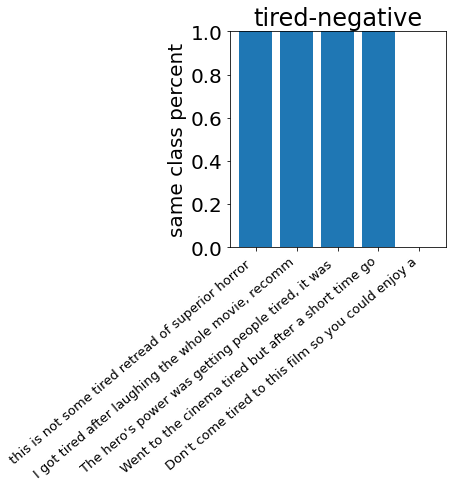

In [182]:
anchors_percent(anchor_sentences)

In [164]:
x1 = predict_sentences(counter_test[:200])
x2 = predict_sentences(counter_test[200:400])
x3 = predict_sentences(counter_test[400:600])
x4 = predict_sentences(counter_test[600:800])
x5 = predict_sentences(counter_test[800:])

In [159]:
all_predictions = np.concatenate([x1,x2,x3,x4,x5])

In [160]:
#labels opposite
sum(prediction == (1-label) for (prediction,label) in zip(all_predictions, counter_test_labels))/len(all_predictions)

0.639344262295082

In [162]:
#negative prediction
sum(all_predictions)/len(all_predictions)

0.7786885245901639

In [185]:
counter_test[10]

'If this is the first of the "Nemesis" films that you have seen, then I strongly urge you to proceed no further. The sequels to "Nebula" prove to be no better...hard to believe considering this entry is bottom-of-the-barrel. This movie tries, but it\'s just not worth your time, folks. Take a nap instead.'

In [196]:
predict_sentences(['I will get home watching this movie, recommending .'])

array([1])

In [194]:
predict_sentences(['bad'])

array([1])